In [1]:
import numpy as np
import random
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.activations import gelu
import pickle
%matplotlib widget

In [2]:
def set_seed(seed: int = 42) -> None:
    '''
    Sets all random seeds for the program (Python, NumPy, and TensorFlow) in order to get reproducible results.
    More information about why to set a random seed reproducible results can be found here:
        https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
    Args:
        seed: an int for the random seed
    '''
    if not isinstance(seed, int):
        raise ValueError(
            'Expected `seed` argument to be an integer. '
            f'Received: seed={seed} (of type {type(seed)})')
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    K._SEED_GENERATOR.generator = random.Random(seed)
    print(f"Random seed set as {seed}")

In [3]:
set_seed(42)

Random seed set as 42


In [4]:
df_cab = pd.read_csv('cab_rides.csv').dropna()
df_cab['time_stamp'] = pd.to_datetime(df_cab['time_stamp'], unit='ms')

In [5]:
df_cab = df_cab.sort_values('time_stamp')

In [6]:
df_weather = pd.read_csv('weather.csv')
df_weather['time_stamp'] = pd.to_datetime(df_weather['time_stamp'], unit='s')
df_weather['rain'] = df_weather['rain'].fillna(0)
df_weather = df_weather.sort_values('time_stamp')

In [7]:
df = pd.merge_asof(df_cab, df_weather, on='time_stamp')

In [8]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,temp,location,clouds,pressure,rain,humidity,wind
0,3.03,Lyft,2018-11-26 03:40:46.318,Theatre District,Boston University,34.0,1.0,ef4771c2-c88d-4730-aaf7-a95751e9d27e,lyft_luxsuv,Lux Black XL,41.02,North End,0.87,1014.4,0.0,0.92,1.59
1,1.30,Uber,2018-11-26 03:40:46.319,Theatre District,South Station,18.5,1.0,00ea74ea-2c49-416c-bfc5-f7877025f6eb,6c84fd89-3f11-4782-9b50-97c468b19529,Black,41.02,North End,0.87,1014.4,0.0,0.92,1.59
2,2.43,Lyft,2018-11-26 03:40:46.320,Beacon Hill,Northeastern University,10.5,1.0,edfc7f44-97e1-48cd-930c-e4fe20e88ac8,lyft,Lyft,41.02,North End,0.87,1014.4,0.0,0.92,1.59
3,2.71,Uber,2018-11-26 03:40:46.320,Fenway,Theatre District,32.0,1.0,6172077a-22de-481b-aae2-b5763c87a6c4,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,41.02,North End,0.87,1014.4,0.0,0.92,1.59
4,2.71,Uber,2018-11-26 03:40:46.320,Fenway,Theatre District,19.5,1.0,8682f9bf-5cc0-4dfc-b8fe-4e22070d1684,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,41.02,North End,0.87,1014.4,0.0,0.92,1.59


In [9]:
features = ['cab_type', 'name', 'temp', 'clouds', 'rain', 'humidity', 'wind', 'time_stamp', 'distance']
df_X = df[features].copy()
df_X['hour'] = df_X['time_stamp'].dt.hour
df_X = df_X[(df_X.cab_type == 'Uber') & (df_X.name == 'UberX')].drop(['cab_type', 'name', 'time_stamp'], axis=1)
df_y = df[(df.cab_type == 'Uber') & (df.name == 'UberX')]['price']

In [10]:
df_X.head()

,temp,clouds,rain,humidity,wind,distance,hour
4,41.02,0.87,0.0,0.92,1.59,2.71,3
7,41.02,0.87,0.0,0.92,1.59,2.19,3
15,41.02,0.87,0.0,0.92,1.59,0.56,3
51,41.02,0.87,0.0,0.92,1.59,1.71,3
56,41.02,0.87,0.0,0.92,1.59,2.05,3


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_X.to_numpy(), 
                                                    np.round(df_y).to_numpy())

def z_standardize(x, mu, sigma):
    return (x - mu) / sigma

mu = X_train.mean(axis=0).reshape(1, -1)
sigma = X_train.std(axis=0).reshape(1, -1)

X_train = z_standardize(X_train, mu=mu, sigma=sigma)
X_test = z_standardize(X_test, mu=mu, sigma=sigma)

In [12]:
scales = np.vstack([mu, sigma])

In [13]:
np.save('scales.npy', scales)

In [14]:
X_train.shape, y_train.shape

((41320, 7), (41320,))

In [15]:
def MLP(input_shape=(7,)):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation=gelu)(inputs)
    x = Dense(128, activation=gelu)(x)
    x = Dense(64, activation=gelu)(x)
    x = Dense(32, activation=gelu)(x)
    x = Dense(1, activation='linear')(x)
    
    return Model(inputs, x)

In [16]:
model = MLP()

Metal device set to: Apple M1 Pro


2022-10-15 16:56:58.732817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-15 16:56:58.733005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 45,313
Trainable params: 45,313
Non-trainable p

In [18]:
model.compile(optimizer='Adam', loss='mae', metrics='mae')

In [19]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20


2022-10-15 16:56:59.903135: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/517 [..............................] - ETA: 3:26 - loss: 10.1136 - mae: 10.1136

2022-10-15 16:57:00.130264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


517/517 [==============================] - ETA: 0s - loss: 1.6694 - mae: 1.6694

2022-10-15 16:57:03.515147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


517/517 [==============================] - 4s 7ms/step - loss: 1.6694 - mae: 1.6694 - val_loss: 1.0802 - val_mae: 1.0802
Epoch 2/20
517/517 [==============================] - 3s 7ms/step - loss: 1.0617 - mae: 1.0617 - val_loss: 1.0411 - val_mae: 1.0411
Epoch 3/20
517/517 [==============================] - 4s 7ms/step - loss: 1.0563 - mae: 1.0563 - val_loss: 1.0425 - val_mae: 1.0425
Epoch 4/20
517/517 [==============================] - 4s 7ms/step - loss: 1.0523 - mae: 1.0523 - val_loss: 1.0617 - val_mae: 1.0617
Epoch 5/20
517/517 [==============================] - 3s 7ms/step - loss: 1.0535 - mae: 1.0535 - val_loss: 1.0423 - val_mae: 1.0423
Epoch 6/20
517/517 [==============================] - 3s 7ms/step - loss: 1.0464 - mae: 1.0464 - val_loss: 1.0505 - val_mae: 1.0505
Epoch 7/20
517/517 [==============================] - 3s 7ms/step - loss: 1.0354 - mae: 1.0354 - val_loss: 0.9928 - val_mae: 0.9928
Epoch 8/20
517/517 [==============================] - 4s 7ms/step - loss: 1.0049 - mae:

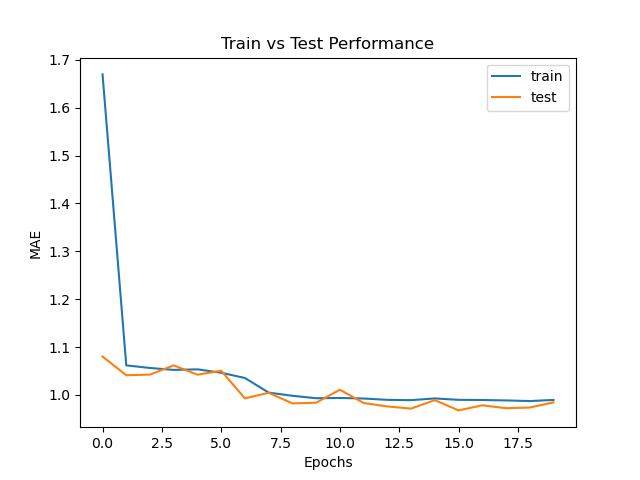

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist.history['mae'], label='train')
ax.plot(hist.history['val_mae'], label='test')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
ax.set_title('Train vs Test Performance')
ax.legend()

In [21]:
model.save('MLP_model.h5')